In [ ]:
#Install Libraries

#!pip install numpy
#!pip install pandas
#!pip install sklearn
#!pip install scipy

In [ ]:
#Import Libraries
import csv
import random
import numpy as np
import pandas as pd
import re
import string
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger') 
from nltk.corpus import stopwords
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer 
nltk.download("wordnet")
from scipy.cluster.hierarchy import ward, dendrogram

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.preprocessing import normalize
import scipy.cluster.hierarchy as sch

%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [ ]:
df = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/metadata.csv',low_memory = False)
# df = pd.read_csv('metadata.csv')

# Hypothesis

What do abstracts from covid journals say about PPE, medicine, disinfect, exercise, and diet? For example, when someone says to use PPE, what kind of PPE should we be expecting to see and what can be inffered from them? When someone says diet, what type of diet or similar keywords we can expect. Etc...

In [ ]:
check_list = ['ppe', 'medicine', 'disinfect', 'exercise', 'diet']

# 1. Data Cleaning

The focus is on the text. Therefore, title and abstract are sufficient. 

In [ ]:
# Extract only useful columns
df = df[['title','abstract','journal']]
df = df.drop_duplicates(subset='abstract', keep="first")
df=df.dropna()
df["abstract"] = df["abstract"].str.lower()
df.reset_index(inplace = True)
df.head()

,index,title,abstract,journal
0,0,Clinical features of culture-proven Mycoplasma...,objective: this retrospective chart review des...,BMC Infect Dis
1,1,Nitric oxide: a pro-inflammatory mediator in l...,inflammatory diseases of the respiratory tract...,Respir Res
2,2,Surfactant protein-D and pulmonary host defense,surfactant protein-d (sp-d) participates in th...,Respir Res
3,3,Role of endothelin-1 in lung disease,endothelin-1 (et-1) is a 21 amino acid peptide...,Respir Res
4,4,Gene expression in epithelial cells in respons...,respiratory syncytial virus (rsv) and pneumoni...,Respir Res


In [ ]:
df.shape

(297207, 4)

Create function for data cleaning.

1. `stop_words_removal` function is to remove stopwords. Since the model is going to be Word2Vec, this function is not necessary for the main dataframe. By removing stopwords, one might remove the dependency information of the words from the document (sentence). However, this function will be used for second dataframe which the purpose to create visualization with cleaner data(stop words removed)

2. `clean_text_sa` function is to clean up special characters such as non-alphabetical characters.

3. `spacing_token` function is to tokenize document (sentence).

4. `lemm_lemm` function is to lemmatize each word. Lemmatizing is used over stemming because lemmatized words still maintain the integrity of the word while stemming will cut down the word until the root word that hardly can be deciphered by human. Lemmatizing also convert plural word to singular word.

In [ ]:
def stop_words_removal(df):
  #remove stopwords
  stopwords = nltk.corpus.stopwords.words('english')
  df['stop_abstract'] = df['abstract'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords)]))
  return df

  # data cleaning
def clean_text_sa(text):
  text = re.sub('\n', '', text)
  text = re.sub(r"(?:\@|https?\://)\S+", " ", text)
  text = re.sub('[^A-Za-z\s]+', ' ', text)
  text = re.sub('\b[A-Za-z]\b', ' ', text)
  return text

# function for tokenizing
def spacing_token(text):
  text = re.findall(r'\S+', text)
  return text

def lemm_lemm(df):
  lemmatizer = WordNetLemmatizer()
  df['lemmatized_token'] = df['dirty_token'].apply(lambda x: [lemmatizer.lemmatize(y) for y in x]) # lemmatize every word.
  return df


`clean_text_sa`, `spacing_token`, and `lemm_lemm` functions are called in order to perform data cleaning. The results are stored in `df` dataframe

In [ ]:
df['clean_abstract'] = df['abstract'].apply(clean_text_sa) # data cleaning
df['dirty_token'] = df['clean_abstract'].apply(spacing_token) #tokenize
lemm_lemm(df) # lemmatizing

For visualization purpose, separate feature based on abstract is created with stopwords were removed. These were only run once because google colab RAM is not sufficient in running them. The codes above and below were run separately and pickled later to keep the RAM usage minimum.

In [ ]:
stop_words_removal(df)
df['stop_abstract'] = df['stop_abstract'].apply(clean_text_sa) # data cleaning
df['stop_abstract'] = df['stop_abstract'].apply(spacing_token) #tokenize

Separating the dataframe needed. `stopword_df` contains tokenized word that has stopwords removed. The purpose of that is the get the most common words. 

`df` contains lemmatized token that is ready to be used for word2vec model

In [ ]:
stopword_df = df[['title','stop_abstract']]
df = df[['title','lemmatized_token']]

The two dataframes above were pickled so that we do not have to keep cleaning the data. Pickled data will be saved into the directory chosen. In this case, it is saved on my google drive. (Commented because they were run once in my computer)

In [ ]:
# stopword_df.to_pickle('/content/gdrive/MyDrive/Colab Notebooks/final_1624_df_stop_abstract.pkl')
# df.to_pickle('/content/gdrive/MyDrive/Colab Notebooks/final_1624_df.pkl')

Importing pickled dataframe from the directory chosen. In this case, it is imported from my google drive. 

In [ ]:
# stopword_df = pd.read_pickle("/content/gdrive/MyDrive/Colab Notebooks/final_1624_df_stop_abstract.pkl")
# df = pd.read_pickle("/content/gdrive/MyDrive/Colab Notebooks/final_1624_df.pkl")

#2a. Data Visualization & EDA

When exploring the NLP data, the question that can be asked is what are the most common words used. Also whether or not the keywords selected on the hypothesis show on the most common words.

As expected, `covid` is the highest since the focus of the journal is talking about covid. 

In [ ]:
flat_token = [item for sublist in stopword_df.stop_abstract.to_list() for item in sublist] # combined list in df into giant list
from collections import Counter
stopwords_removed_list = Counter(flat_token).most_common(15)
print(stopwords_removed_list) # print out 15 most common words from stopword_df

[('covid', 458577), ('patients', 378178), ('sars', 175967), ('study', 174635), ('cov', 173106), ('disease', 168320), ('health', 165115), ('results', 160866), ('pandemic', 151652), ('p', 139894), ('infection', 130036), ('coronavirus', 118325), ('clinical', 117208), ('data', 116175), ('virus', 112610)]


For better visualization, bar plot is selected as it can be used to see how one word occured more than the other.

###1. Number of occurrences on the most common keywords

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


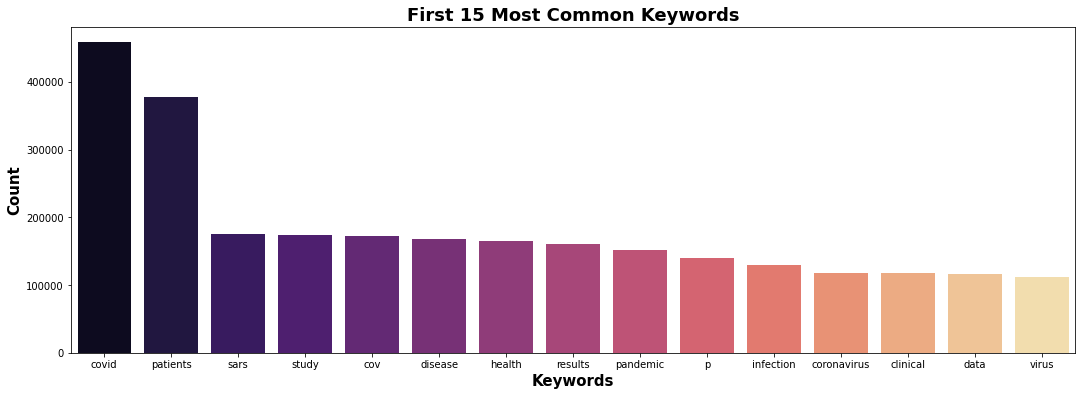

In [ ]:
# splitting key and value
stopwords_key = []
stopwords_value = []
for i in range(len(stopwords_removed_list)):
  stopwords_key.append(stopwords_removed_list[i][0])
  stopwords_value.append(stopwords_removed_list[i][1])

# create bar plot
plt.figure(figsize=(18, 6))
sns.barplot(stopwords_key, stopwords_value, palette='magma')
plt.title("First 15 Most Common Keywords",fontsize = 18, fontweight = 'bold')
plt.xlabel("Keywords",fontsize = 15, fontweight = 'bold')
plt.ylabel('Count',fontsize = 15, fontweight = 'bold')
plt.show()

None of the keywords from the hypothesis are shown in this bar plot. 

Next is to check the frequency of hypothesis keywords in this dataset.

In [ ]:
check_list = ['ppe', 'medicine', 'disinfect', 'exercise', 'diet']
topic_count = {}
for i in check_list:
  topic_count[i] = 0

for i in topic_count:
  for j in df['lemmatized_token']:
    if str(i) in j:
      topic_count[i] += 1

print(topic_count)

{'ppe': 2554, 'medicine': 10800, 'disinfect': 157, 'exercise': 3136, 'diet': 2060}


The number of occurrences are not very high compared to the most common words. 
Next step is to check if a keyword from intuition is discussed in this dataset.

Expected keyword from intuition:
- `facemask` to be categorized as `ppe`
- `inhaler` to be categorized as `medicine`
- `wash` to be categorized as `disinfect`
- `ketogenic` to be categorized as `diet`

The keywords above are expected to be written in the journal. To roughly check, counting their frequencies can be used again.

In [ ]:
sub_check_list = ['facemask', 'inhaler', 'wash', 'ketogenic']

sub_topic_count = {}
for i in sub_check_list:
  sub_topic_count[i] = 0

for i in sub_topic_count:
  for j in df['lemmatized_token']:
    if str(i) in j:
      sub_topic_count[i] += 1

print(sub_topic_count)

{'facemask': 210, 'inhaler': 122, 'wash': 548, 'ketogenic': 40}


The counts are very small but they exist. This means there could be chances that these keyword will appear later on during model selection and word similarities / clustering.

###2. Distribution of each keywords on pie chart

How are the distribution of hypothesis keywords against the most common word in the dataset? 

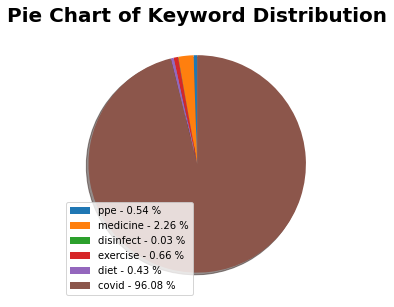

In [ ]:
bar_list = list(topic_count.keys())
bar_list.append('covid')
bar_values = list(topic_count.values())
bar_values.append(458577)
e = np.array(bar_values)
porcent = 100.*e/e.sum()
pct_labels = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(bar_list, porcent) ] # legend contains key and values

plt.figure(figsize=(5, 5))
plt.pie(bar_values, startangle = 90, \
        shadow = True, textprops={'fontsize': 10})
plt.title("Pie Chart of Keyword Distribution", fontweight = 'bold', fontsize=20)
plt.legend(pct_labels, loc = 'lower left')
plt.show()

The keyword covid being the most occured keyword in the dataset takes up about 96% of the whole pie chart. While the rest only takes around 4%. By just looking at chart, the topics selected seem to be really small but they are gathered from 297207 journals. From this EDA, intuitively based on word count,it can be implied journals are focusing more on the symptoms but not its subsidiary topics such as the topic selected (hypothesis keywords).

###More EDA visualization after Word2Vec

#3. Model Selection

Word2Vec is selected as the model selection for this topic because Word2Vec can detect synonymous words. This will be very useful as the model will let the user knows which words are the most similar to the hypothesis keywords. After finding word similarities, clusters can be created to group together each keyword using hierarichal clustering.

Library from gensim provides Word2Vec class that can be trained to create the model for this dataset.

Parameters used on gensim.models.Word2Vec:
- `sentences` is the input of the words. It has to be in a tokenized corpus form
- `size` is the dimension of the embedding. Here, dimension chosen is 100. Typically the range of size is between 100-1000. Here, dimension of 100 is chosen as the dataset is large enough.
- `window` is the maximum distance between each word. Value selected is 5.
- `workers` is the number of thread. The purpose is to speed up training. Value selected is 4.
- `min_count` is the minimum number of words to be considered when training the model. 1 is selected because we want to train all the available vocabularies.

In [ ]:
word_embed_corpus = df['lemmatized_token'].to_list() # corpus with tokenized 

import gensim
# train model
EMBEDDING_DIM = 100 # dimensionality 
model = gensim.models.Word2Vec(sentences=word_embed_corpus, size=EMBEDDING_DIM, window=5, workers=4, min_count=1)
words = list(model.wv.vocab)
print('Vocabulary size: %d' % len(words))

Custom-trained word2vec is saved (pickle) to .sav file so the model doesn't need to be trained on every runtime.

In [ ]:
import pickle
# saving model to gdrive
# pickle.dump(model, open('/content/gdrive/MyDrive/Colab Notebooks/covid_model_big.sav', 'wb'))
# accessing pickle model
# model = pickle.load(open('/content/gdrive/MyDrive/Colab Notebooks/covid_model_big.sav', 'rb')) # word2vec model

###Testing Word2Vec Word Similarity

The code below can be used to check semantic word. Given any word that is in the journal, the model will tell what word has the similar word with the input. For instance, the input of `eat` has similarities of `consume` the remaining list below. The values of listed below are not percetage similarities. They are cosine similarities. The higher the cosine similarities, the closer they are in terms of semantic meaning.


***NOTE*** : According to https://github.com/RaRe-Technologies/gensim/wiki/Recipes-&-FAQ#q11-ive-trained-my-word2vecdoc2vecetc-model-repeatedly-using-the-exact-same-text-corpus-but-the-vectors-are-different-each-time-is-there-a-bug-or-have-i-made-a-mistake-2vec-training-non-determinism , under Q11 Radim himself wrote there will be random initialization. Therefore, vectors can change a little bit and it may cause the most similar words to vary each time the model is trained. There is no `random_state` parameter in the class. Radim suggested to reduce its worker = 1 but the vectors can vary as well. After many trials, the word that's at top 5 were mostly consistent.

In [ ]:
model.wv.most_similar('eat') # input can be change to any word from this dataset

[('consume', 0.7272949814796448),
 ('drink', 0.7083439826965332),
 ('snack', 0.6970993280410767),
 ('cooked', 0.6695696115493774),
 ('sell', 0.6377986669540405),
 ('nutritious', 0.6366808414459229),
 ('snacking', 0.6167173981666565),
 ('sugary', 0.6068333387374878),
 ('nutritiously', 0.6062142848968506),
 ('buy', 0.5871038436889648)]

#2b. Data Visualization & EDA (continuation)

Create list of most similar keywords based on the hypothesis keywords.

In [ ]:
check_list = ['ppe', 'medicine', 'disinfect', 'exercise', 'diet']

big_top_list = []

for i in check_list:
  temp_holder = []
  for j in range(10):
    temp_holder.append(model.wv.most_similar(i)[j][0]) # append most similar words per hypothesis keyword
  big_top_list.append(temp_holder) # contains list of most similar word list

In [ ]:
for i in range(len(check_list)):
  print(check_list[i])
  print(big_top_list[i])
  print("")

ppe
['ppes', 'equipment', 'facemask', 'facemasks', 'mask', 'glove', 'respirator', 'doffing', 'gear', 'goggles']

medicine
['unani', 'ayurvedic', 'ayurveda', 'healer', 'cardiology', 'pediatrics', 'allopathic', 'siddha', 'psychiatry', 'homoepathy']

disinfect
['decontaminate', 'sterilize', 'sanitize', 'disinfected', 'disinfecting', 'bathroom', 'remove', 'exhaust', 'cleaning', 'sterilized']

exercise
['endurance', 'aerobic', 'meditation', 'yoga', 'training', 'walking', 'exercising', 'treadmill', 'mbsr', 'mindfulness']

diet
['dietary', 'calorie', 'intake', 'ketogenic', 'micronutrient', 'lifestyle', 'gluten', 'macronutrient', 'nutritious', 'snack']



Some plural words cannot be removed using lemmatizing because they might not be real English word from English dictionary. Therefore, more tedious work in manually check the top 10 most similar words based on the hypothesis keyword and remove if there's a duplicate. For instance under ppe category, there is a keyword `ppes` which can be removed as it's just ppe in plural form.

***NOTE***: The lists below vary on each time model is trained. Since I saved my model in my gdrive, the result will be the same and the duplicates will be the same as well.


Remove duplicate keywords:


In [ ]:
ppe_duplicate = ['ppes', 'equipment', 'facemasks', 'gear']
medicine_duplicate = ['ayurvedic']
disinfect_duplicate = ['disinfected', 'disinfecting', 'remove']
exercise_duplicate = ['exercising', 'training']

big_top_list[0] = [e for e in big_top_list[0] if e not in ppe_duplicate] # remove selected keyword on ppe
big_top_list[1] = [e for e in big_top_list[1] if e not in medicine_duplicate] # remove selected keyword on medicine
big_top_list[2] = [e for e in big_top_list[2] if e not in disinfect_duplicate] # remove selected keyword on disinfect
big_top_list[3] = [e for e in big_top_list[3] if e not in exercise_duplicate] # remove selected keyword on exercise

After removing the duplicates, number of counts can be calculated to create a word cloud to easily visualize the count of each word compared to others.

Count dictionary key and values for visualization:

In [ ]:
ppe_count = dict((i,0) for i in big_top_list[0])
medicine_count = dict((i,0) for i in big_top_list[1])
disinfect_count = dict((i,0) for i in big_top_list[2])
exercise_count = dict((i,0) for i in big_top_list[3])
diet_count = dict((i,0) for i in big_top_list[4])

for i in ppe_count:
  for j in df['lemmatized_token']:
    if str(i) in j:
      ppe_count[i] += 1

for i in medicine_count:
  for j in df['lemmatized_token']:
    if str(i) in j:
      medicine_count[i] += 1

for i in disinfect_count:
  for j in df['lemmatized_token']:
    if str(i) in j:
      disinfect_count[i] += 1

for i in exercise_count:
  for j in df['lemmatized_token']:
    if str(i) in j:
      exercise_count[i] += 1

for i in diet_count:
  for j in df['lemmatized_token']:
    if str(i) in j:
      diet_count[i] += 1

Print out the count of selected keywords. These can be visualize using word cloud to see how big each word is compared to others.

In [ ]:
print(ppe_count)
print(medicine_count)
print(disinfect_count)
print(exercise_count)
print(diet_count)

{'facemask': 210, 'mask': 5123, 'glove': 768, 'respirator': 1107, 'doffing': 254, 'goggles': 202}
{'unani': 29, 'ayurveda': 138, 'healer': 30, 'cardiology': 556, 'pediatrics': 450, 'allopathic': 50, 'siddha': 23, 'psychiatry': 547, 'homoepathy': 3}
{'decontaminate': 96, 'sterilize': 31, 'sanitize': 26, 'bathroom': 74, 'exhaust': 134, 'cleaning': 924, 'sterilized': 77}
{'endurance': 187, 'aerobic': 323, 'meditation': 132, 'yoga': 130, 'walking': 608, 'treadmill': 93, 'mbsr': 16, 'mindfulness': 287}
{'dietary': 1370, 'calorie': 156, 'intake': 1578, 'ketogenic': 40, 'micronutrient': 253, 'lifestyle': 2155, 'gluten': 66, 'macronutrient': 30, 'nutritious': 86, 'snack': 110}


###3. WordCloud

Creating mini wordcloud per category

(-0.5, 799.5, 399.5, -0.5)

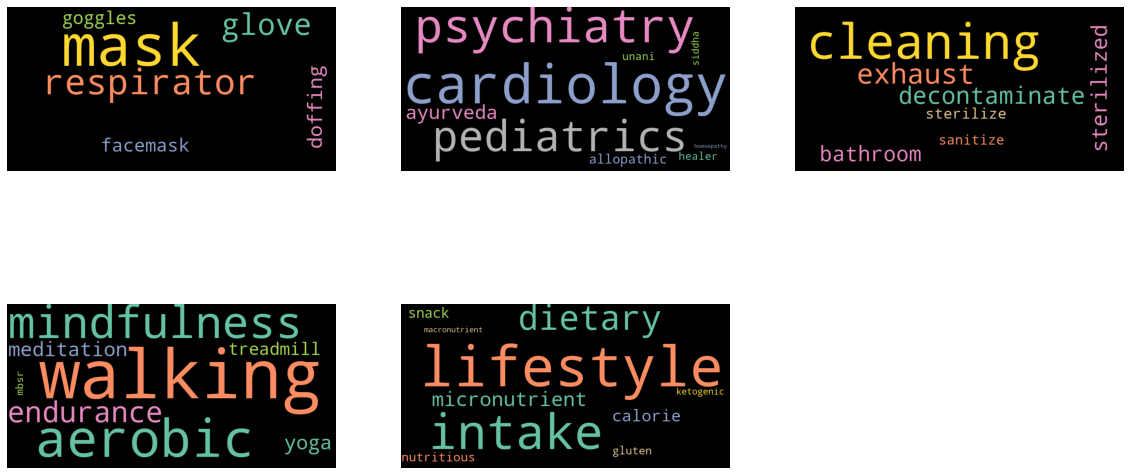

In [ ]:
# ppe word cloud
plt.figure( figsize=(20,10))
plt.subplot(2,3,1)
ppe_cloud = WordCloud(width=800, height=400, colormap = 'Set2', random_state = 23).generate_from_frequencies(ppe_count)
plt.imshow(ppe_cloud)
plt.axis("off")

# medicine word cloud
plt.subplot(2,3,2)
ppe_cloud = WordCloud(width=800, height=400, colormap = 'Set2', random_state = 23).generate_from_frequencies(medicine_count)
plt.imshow(ppe_cloud)
plt.axis("off")

# disinfect word cloud
plt.subplot(2,3,3)
ppe_cloud = WordCloud(width=800, height=400, colormap = 'Set2', random_state = 23).generate_from_frequencies(disinfect_count)
plt.imshow(ppe_cloud)
plt.axis("off")

# exercise word cloud
plt.subplot(2,3,4)
ppe_cloud = WordCloud(width=800, height=400, colormap = 'Set2', random_state = 23).generate_from_frequencies(exercise_count)
plt.imshow(ppe_cloud)
plt.axis("off")

# diet word cloud
plt.subplot(2,3,5)
ppe_cloud = WordCloud(width=800, height=400, colormap = 'Set2', random_state = 23).generate_from_frequencies(diet_count)
plt.imshow(ppe_cloud)
plt.axis("off")

Separated word clouds are not that useful as the number of keyword per categories are too small. Therefore they can be combined to see how different are they in terms of count.

Combined WordCloud

(-0.5, 799.5, 399.5, -0.5)

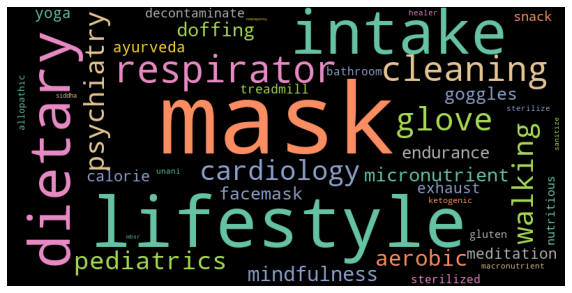

In [ ]:
z = {**ppe_count, **medicine_count, **disinfect_count, **exercise_count, **diet_count} # combine dictionaries

# combined word cloud
plt.figure( figsize=(10,8))
ppe_cloud = WordCloud(width=800, height=400, colormap = 'Set2', random_state = 23).generate_from_frequencies(z)
plt.imshow(ppe_cloud)
plt.axis("off")

From this combined word cloud, the keyword `mask`, `dietary`, and `lifestyle` are large and therefore it indicates they are frequently used more than the other keywords in this word cloud.

###4. Bar plot distribution of similar words

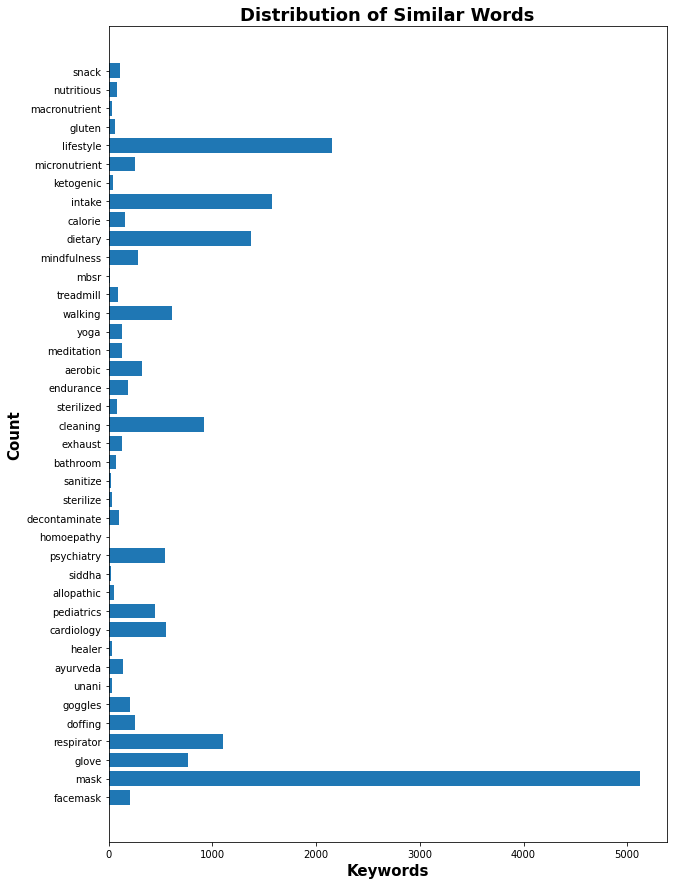

In [ ]:
plt.figure(figsize=(10, 15))
plt.barh(list(z.keys()), z.values())
plt.title("Distribution of Similar Words",fontsize = 18, fontweight = 'bold')
plt.xlabel("Keywords",fontsize = 15, fontweight = 'bold')
plt.ylabel('Count',fontsize = 15, fontweight = 'bold')
plt.show()

`mask`, `gloves`, `respirators`, `lifestyle`, `cleaning`, `dietary`, and `intake` are discussed more often.

##Word2Vec Clustering Model


In [ ]:
# flatten the list for distance computation
flat_list = [item for sublist in big_top_list for item in sublist]

Word2Vec from gensim library also provides the cosine distance between each word. There are two distances that can be computed here, euclidean distance and cosine distance. For text data, cosine distance is prefered because it measures the angle and ignore its magnitude. The smaller the angle of 2 keyword, the higher its cosine similarity. 

- cosine similarities range is between -1 to 1
- cosine distance = 1 - cosine similarities




In [ ]:
# calculating euclidean distance and cosine distance between prevention keywords
euclidean_matrix = []
cosine_matrix = []
for i in flat_list:
  temp_euclidean = []
  temp_cosine = []
  for j in flat_list:
    temp_euclidean.append(np.linalg.norm(model.wv[i] - model.wv[j])) # will not be used
    temp_cosine.append(model.wv.distance(i,j)) # will be used
  euclidean_matrix.append(temp_euclidean)
  cosine_matrix.append(temp_cosine)

euclidean_dist_array = np.array(euclidean_matrix)
cosine_dist_array = np.array(cosine_matrix)

In [ ]:
euclidean_df = pd.DataFrame(data = euclidean_dist_array, columns = flat_list, index = flat_list) # euclidean distance matrix (not used)
cosine_df = pd.DataFrame(data = cosine_dist_array, columns = flat_list, index = flat_list) # cosine distance matrix (will be used)

Distance matric is stored in dataframe for easy visualization. The higher the number, the less likely those words are similar. For example, `sterilized` and `cardiology` are not similar and they have high distance. 

In [ ]:
cosine_df

,facemask,mask,glove,respirator,doffing,goggles,unani,ayurveda,healer,cardiology,pediatrics,allopathic,siddha,psychiatry,homoepathy,decontaminate,sterilize,sanitize,bathroom,exhaust,cleaning,sterilized,endurance,aerobic,meditation,yoga,walking,treadmill,mbsr,mindfulness,dietary,calorie,intake,ketogenic,micronutrient,lifestyle,gluten,macronutrient,nutritious,snack
facemask,0.000000,0.117539,2.303020e-01,0.245200,5.355268e-01,0.252654,0.914906,0.873805,9.892636e-01,1.051052,1.005770,0.946598,0.884569,1.107875,0.931537,0.527085,4.788990e-01,0.537508,5.876652e-01,6.487585e-01,0.491422,5.651113e-01,0.885416,0.920035,0.721738,7.654528e-01,0.824421,0.773390,0.847929,0.840067,0.877476,0.836365,9.176355e-01,0.947487,0.923639,0.945681,0.921792,0.917267,0.897559,7.698753e-01
mask,0.117539,0.000000,2.381202e-01,0.186332,5.629269e-01,0.252362,0.967530,0.915246,9.154400e-01,1.016855,1.003575,0.978906,0.947290,1.052008,0.912180,0.557931,5.119247e-01,0.575832,5.924188e-01,6.817022e-01,0.537922,5.763117e-01,0.829300,0.943163,0.763279,7.955875e-01,0.769392,0.784778,0.810645,0.839614,0.921919,0.875090,9.565264e-01,1.045769,0.959493,0.892367,0.983887,0.963199,0.910005,8.237144e-01
glove,0.230302,0.238120,5.960464e-08,0.306413,4.114791e-01,0.158735,0.853850,0.867130,8.850556e-01,1.027183,0.942692,0.876296,0.853721,1.083913,0.842368,0.458803,3.979672e-01,0.375913,3.606715e-01,6.013501e-01,0.376271,3.899372e-01,0.890091,0.930814,0.769522,8.006171e-01,0.804084,0.757751,0.877525,0.907986,0.921988,0.814413,8.730326e-01,0.925070,0.988893,0.937433,0.846710,0.879768,0.779418,7.352422e-01
respirator,0.245200,0.186332,3.064128e-01,0.000000,5.077189e-01,0.292480,0.974772,0.989093,1.055880e+00,1.031249,1.040121,0.956273,0.934222,1.114180,0.994445,0.444444,4.921128e-01,0.578396,6.323757e-01,6.010348e-01,0.530931,4.775261e-01,0.815923,0.855796,0.900606,9.063440e-01,0.799690,0.731093,0.806558,0.961206,0.951618,0.859569,9.674822e-01,0.994628,0.911854,0.998951,0.938777,0.929970,0.915048,8.957994e-01
doffing,0.535527,0.562927,4.114791e-01,0.507719,5.960464e-08,0.431087,0.943605,0.973415,1.004692e+00,1.002376,0.985587,1.010702,0.919451,1.089683,1.064187,0.509485,5.605037e-01,0.540914,6.584942e-01,7.656307e-01,0.373938,6.149968e-01,0.786093,0.866239,0.789338,7.933865e-01,0.727144,0.766118,0.804379,0.853102,0.936209,0.937256,9.037609e-01,1.006518,1.101254,0.994326,1.031463,0.952787,0.988274,9.216869e-01
goggles,0.252654,0.252362,1.587349e-01,0.292480,4.310870e-01,0.000000,0.804376,0.876004,8.863988e-01,0.933025,0.881762,0.878024,0.844971,0.987709,0.817549,0.458848,3.907349e-01,0.392904,4.642568e-01,6.256985e-01,0.438750,4.385006e-01,0.835082,0.936669,0.768472,7.612845e-01,0.775860,0.757084,0.801194,0.860679,0.926006,0.790544,8.567891e-01,0.931955,0.905802,0.968088,0.853039,0.879677,0.812280,7.771985e-01
unani,0.914906,0.967530,8.538499e-01,0.974772,9.436045e-01,0.804376,0.000000,0.214525,4.762294e-01,0.580760,0.423583,0.368541,0.191658,0.624019,0.380414,0.896408,8.565402e-01,0.878386,1.025686e+00,1.055825e+00,0.809734,8.964215e-01,1.000633,0.949233,0.686692,5.201015e-01,1.023264,0.993827,0.895510,0.869798,0.789558,0.983737,9.969125e-01,0.748427,0.867409,0.914447,0.737792,0.870036,0.871110,8.911703e-01
ayurveda,0.873805,0.915246,8.671305e-01,0.989093,9.734154e-01,0.876004,0.214525,0.000000,5.460156e-01,0.753302,0.529103,0.501714,0.287210,0.706101,0.404000,0.933404,8.660577e-01,0.898668,1.028841e+00,1.091351e+00,0.813568,9.408663e-01,1.108994,1.023552,0.736221,5.584640e-01,1.037421,1.085620,1.002928,0.834089,0.730495,0.955670,9.515245e-01,0.680624,0.785418,0.792880,0.692537,0.930739,0.794658,8.939969e-01
healer,0.989264,0.915440,8.850556e-01,1.055880,1.004692e+00,0.886399,0.476229,0.546016,5.960464e-08,0.753864,0.699654,0.517505,0.521740,0.633650,0.482319,1.023678,9.573363e-01,0.959013,8.737362e-01,1.061894e+00,0.910434,9.453456e-01,1.021905,1.053837,0.762569,6.804451e-01,0.912961,1.059631,0.909183,0.903453,0.949936,1.082627,1.031189e+00,1.028504,1.025021,0.918914,0.952

The shape of cosine matrix is 39x39. Turns out, looking at the number individually can get confusing. Therefore heatmap from seaborn can be implemented here too see some patterns or pre-clusters.

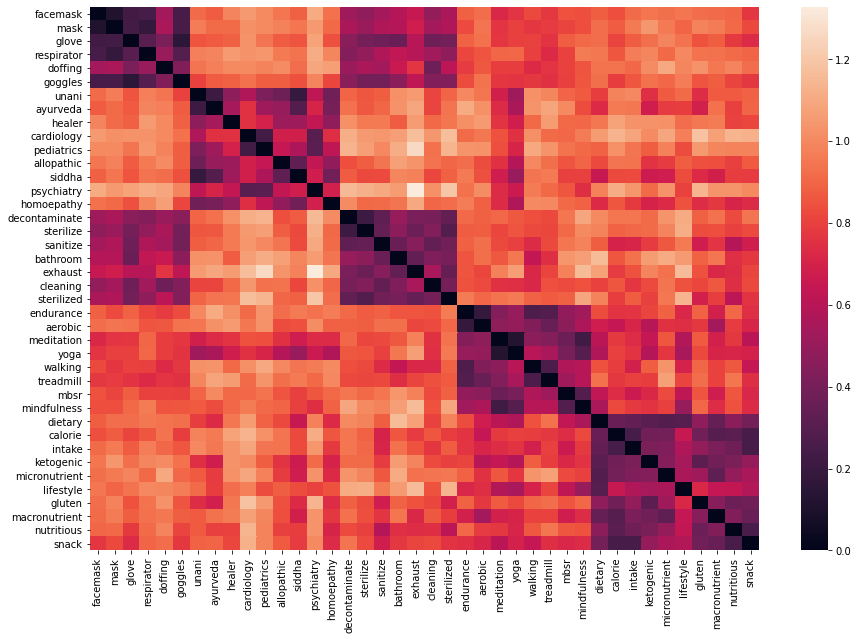

In [ ]:
f, ax = plt.subplots(figsize=(15, 10))
ax = sns.heatmap(cosine_df)

The heatmap depicts cosine distances between words in the brightness of the color. Dark grid means low similarity, and light grid means high similarity. There are some *mini* clusters around the diagonal which are expected because they have less distance between each other. The real clusters should be created using dendrogram.


#Hierarichal clustering with dendrogram

Centroid linkage is chosen for this hierarichal clustering. It means the point can be compared to the average of each cluster.

Text(0.5, 1.0, 'Dendrogram of Four Major Clusters')

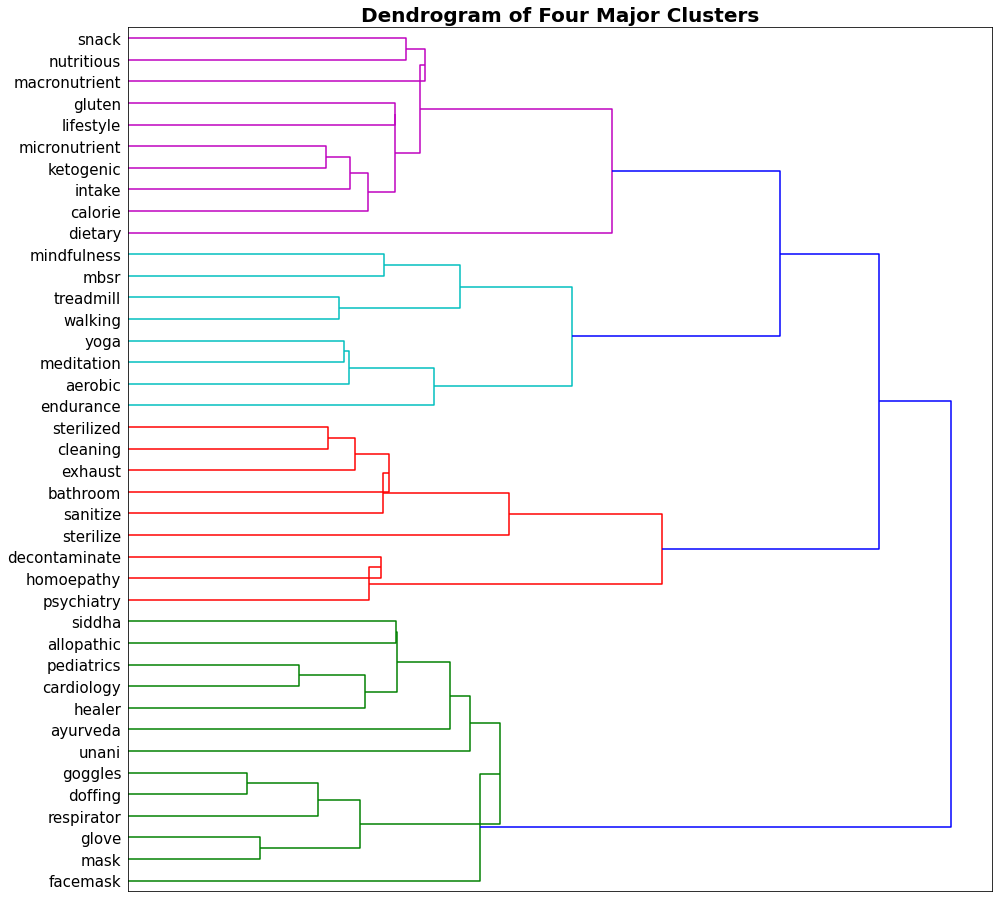

In [ ]:
Y = sch.linkage(cosine_dist_array, method='centroid')

fig = plt.figure(figsize=(30,20))
ax1 = fig.add_axes([0.1,0.1,0.4,0.6])

# Get the dendrogram
Z1 = sch.dendrogram(Y, orientation='right')

ax1.set_xticks([])
ax1.set_yticklabels(flat_list)
ax1.tick_params(axis='y', which='major', labelsize=15)
ax1.set_title("Dendrogram of Four Major Clusters", fontsize=20, fontweight = 'bold')
#plt.savefig('topic_cluster.png', format='png', bbox_inches='tight', dpi=600)

#4. Findings and Insights

According to the dendrogram above, there are 4 major clusteres created. The purple cluster represents `diet`, light blue represents `exercise`, red represents `disinfect`, lastly green represents `ppe` and `medical` combined. This word2vec model successfully clusters topic keyword and determine the word similarities. However, PPE and medical merged together as their cosine distances are not far apart. By intuition ppe and medical are connected in someway. For instance people who work in medical field (doctors and nurses in hospital) wear PPE to treat COVID patients. 

Diet cluster:
- There is `ketogenic` keyword under diet cluster as hoped from earlier EDA. There are many other popular diets such as vegetarian, paleo, raw, but `ketogenic` is the diet that shows up. From this, `ketogenic` can be a topic that can be further investigate that's related to covid

Exercise cluster:
- The exercise mentioned are focused on light activities except `endurance`. There are also some relaxation exercise such as `meditation`, `yoga`, and `mbsr`. These give some insights to investigate more towards light activities that easily be done by majority of people and also convenient as less workout equipments are necessary.

Disinfect cluster:
- This cluster is focused on disinfecting, cleaning, and sterilizing. There is also a word `exhaust` which can be implied there should be ventilation. Researches of these journals can collaborate to further investigate in creating sterilized environments. The interesting keywords here are `homeophaty` and `psychiatry` which are not related to disinfect.

Medical and PPE cluster:
- `facemask`, `gloves`, `goggles`, and `doffing` are the PPE that can be used to prevent getting infected by covid. Since it is an airborne virus, facemask should be the first thing to be worn and the rest can become extra protection. For medical part of this cluster, there are some alternatives medicine mentioned such as `siddha`, `ayurveda`, `healer`, `unani`. `allophatic` is also mentioned in this cluster. From this, there are researches on alternative medicines to see if they can be scientifically proven to combat covid-19. 

In conclusion, using Word2Vec to find word similarity and combine it to dendrogram create a convenient platform for user to immediately identify synonymous words. Using this dendrogram / hierarchical clustering, anyone can identify which keyword belongs to which cluster. This is useful for researchers as they can collaborate to further research and investigate on similar covid topics (same cluster). 